In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

### 문제 1. 데이터 로드 및 탐색

In [3]:
retail = pd.read_excel('online_retail_II.xlsx')

In [7]:
# 1.1 데이터의 첫 5개 행 출력 및 데이터 형식 확인
# 1.2 데이터프레임 컬럼 정보와 결측치 여부 확인
retail.head()
retail.tail()
retail.info()
retail.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


### 문제2. 데이터 전처리

In [10]:
# 2.1 InvoiceData 날짜형으로 변환
# 2.2 CustomerID 결측치 확인 및 제거
retail.isna().mean()
retail.dropna(subset=['Customer ID'], inplace=True)
retail.isna().mean()

Invoice        0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
Price          0.0
Customer ID    0.0
Country        0.0
dtype: float64

In [100]:
# sns.scatterplot(data=retail, x=retail['Price'], y=retail['Quantity'], color='blue')
# plt.title('Price vs Quantity')
# plt.show()

# 2.3 이상치 처리
retail['Price'] = retail['Price'][retail['Price'] > 0]
retail['Quantity'] = retail['Quantity'][(0 < retail['Quantity']) & (retail['Quantity'] < 15000)]

# 2.4 retail 결측치 재확인 및 제거
retail.isna().mean()


Invoice        0.000000
StockCode      0.000000
Description    0.000000
Quantity       0.023567
InvoiceDate    0.000000
Price          0.000074
Customer ID    0.000000
Country        0.000000
Total          0.000000
dtype: float64

In [16]:
# 2.3 customer ID를 정수형으로 변환한 후 , InvoiceDate를 기준으로 데이터 정렬
retail['Customer ID'] = retail['Customer ID'].astype(int)
retail = retail.sort_values(by='InvoiceDate', ascending=True)

In [17]:
# 2.4 금액 total = Quantity * Price 컬럼 생성
retail['Total'] = retail['Quantity']*retail['Price']
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085,United Kingdom,59.5


### 문제3: 나라별 구매 인원 시각화

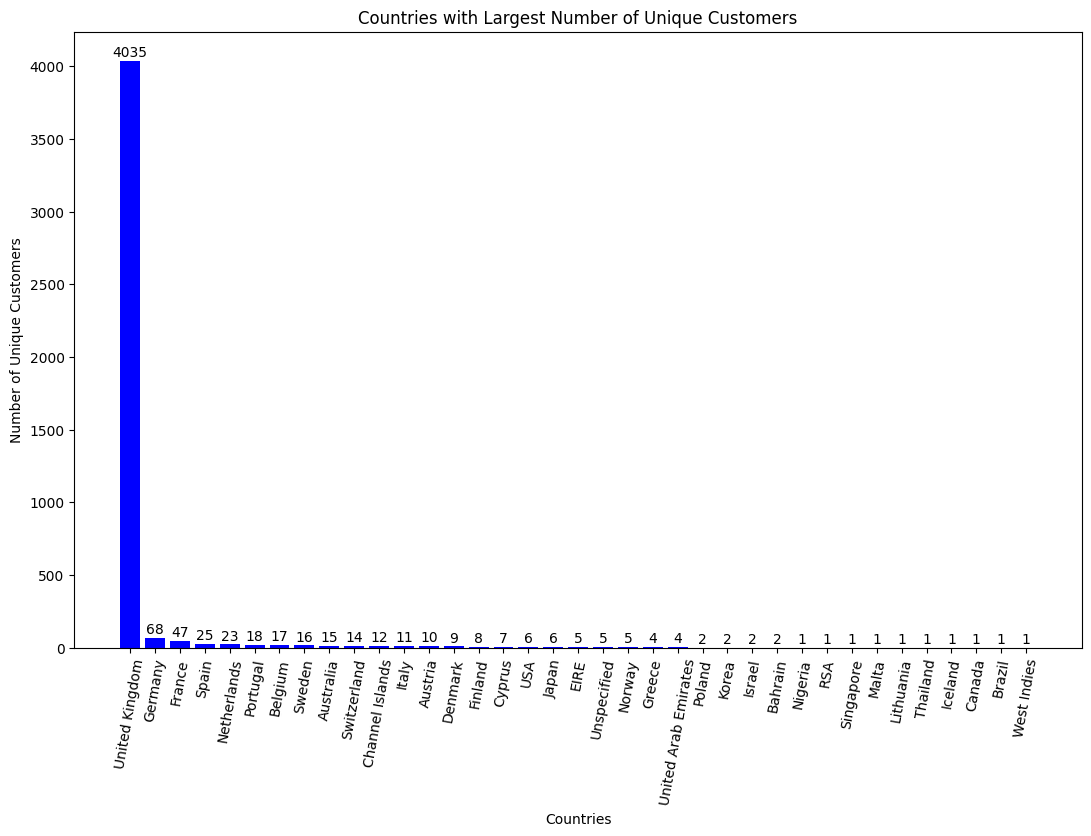

In [26]:
# 3.1 나라별 고객수 시각화
cust_num_country = pd.DataFrame(retail.groupby('Country')['Customer ID'].nunique())
cust_num_country.reset_index(inplace=True)
cust_num_country = cust_num_country.rename(columns={'Customer ID': 'Customer Numbers'})
cust_num_country = cust_num_country.sort_values(by='Customer Numbers', ascending=False)

plt.figure(figsize=(13,8))
cust_num_country_bars = plt.bar(cust_num_country['Country'], cust_num_country['Customer Numbers'], color='blue')

plt.title('Countries with Largest Number of Unique Customers')
plt.xlabel('Countries')
plt.ylabel('Number of Unique Customers')
plt.xticks(rotation=80)

for bar in cust_num_country_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{int(height)}', ha='center', va='bottom')
    

plt.show()

### 문제 4: Acquisition (고객 유입 분석)

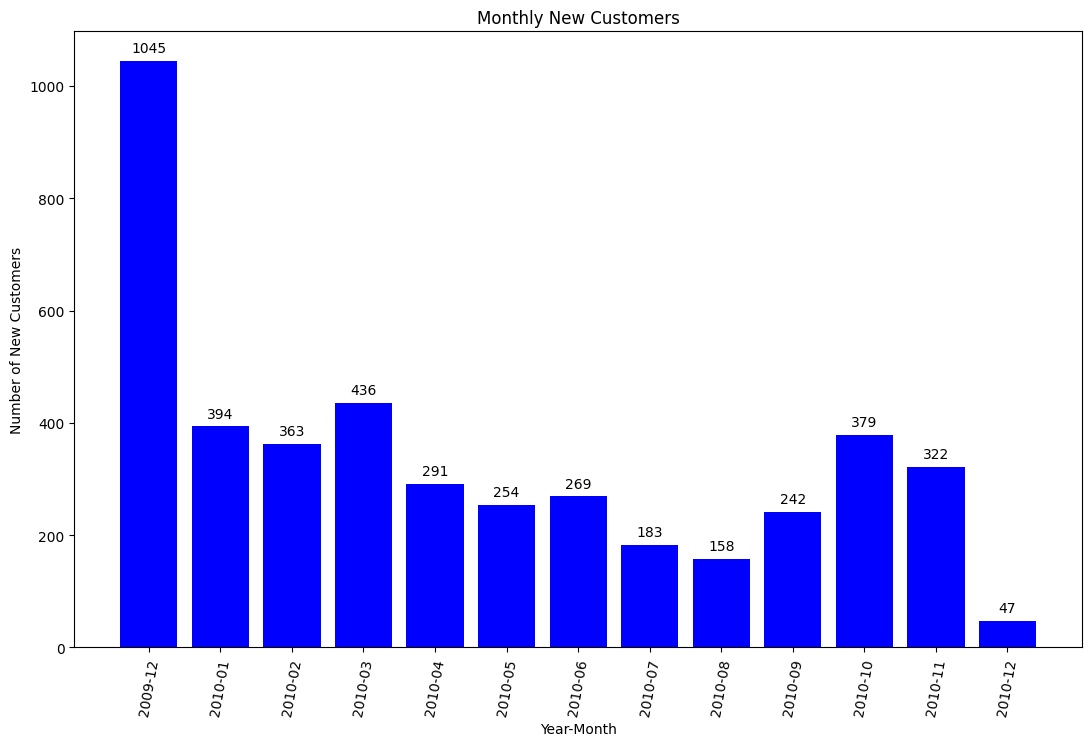

In [81]:
# 4.1 첫 구매시점을 기준으로 월별 신규 유입 고객수 계산
Customer_First_Purchase = pd.DataFrame(retail.groupby('Customer ID')['InvoiceDate'].min())
Customer_First_Purchase.reset_index(inplace=True)
Customer_First_Purchase['Monthly'] = Customer_First_Purchase['InvoiceDate'].dt.to_period('M')

Customer_First_Purchase_Numbers = pd.DataFrame(Customer_First_Purchase.groupby('Monthly')['Customer ID'].nunique())
Customer_First_Purchase_Numbers.reset_index(inplace=True)
Customer_First_Purchase_Numbers.rename(columns={'Customer ID': 'Monthly_New_Customer_Numbers'}, inplace=True)

x = Customer_First_Purchase_Numbers['Monthly'].astype(str)
y = Customer_First_Purchase_Numbers['Monthly_New_Customer_Numbers']

plt.figure(figsize=(13,8))
Customer_First_Purchase_bars = plt.bar(x, y, color='blue')

plt.title('Monthly New Customers')
plt.xlabel('Year-Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=80)

for bar in Customer_First_Purchase_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{int(height)}', ha='center', va='bottom')
    
plt.show()

### 문제 5: Activation (고객 활성화 분석)

In [83]:
retail.groupby('Customer ID')['Total'].sum()

Customer ID
12346     -64.68
12347    1323.32
12348     222.16
12349    2646.99
12351     300.93
          ...   
18283     641.77
18284     436.68
18285     427.00
18286    1188.43
18287    2340.61
Name: Total, Length: 4383, dtype: float64